In [172]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import clear_output

# Prepare MNIST dataset

In [173]:
MNIST_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        (0.1307,), (0.3081,)  # for mean ans std
    )
])

MNIST_inverse_transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x*0.1307 +0.3081),
    torchvision.transforms.ToPILImage()
])

mnist_dataset = torchvision.datasets.MNIST(
    './mnist_datset', train=True, download=True, 
    transform=MNIST_transform
)

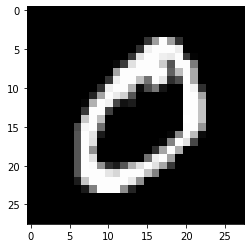

In [174]:
plt.imshow(MNIST_inverse_transform(mnist_dataset[1][0]), cmap='gray')
#plt.imshow((mnist_dataset.data[1]), cmap='gray')
plt.show()

# InfoGAN model

In [194]:
class Generator(nn.Module):
    def __init__(self, noise_size):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(noise_size, 1024, 4, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            #nn.Dropout(p=0.05),
            
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
           # nn.Dropout(p=0.05),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout(p=0.05),
            
            nn.ConvTranspose2d(256, 128, 2, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            #nn.Dropout(p=0.05),
            
            nn.ConvTranspose2d(128, 1, 1, 1, 1, bias=False),
            nn.Tanh()
            #nn.Sigmoid()
        )
        self.noise_size = noise_size
        
    def forward(self, x):
        return self.main(x)
    
class FrontEnd(nn.Module):
    def __init__(self):
        super(FrontEnd, self).__init__()
        
        self.main = nn.Sequential(
            
            nn.Conv2d(1, 128, 1, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
           # nn.Dropout(p=0.05),
            
            nn.Conv2d(128, 256, 2, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.05),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
          #  nn.Dropout(p=0.05),
            
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
         #  nn.Dropout(p=0.05),
        )
    
    def forward(self, x):
        return self.main(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(1024, 1, 4, 1, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.main(x)
        #return self.main(x).view(-1, 1)
        return x.view(-1,1)
    
class Q(nn.Module):
    def __init__(self):
        super(Q, self).__init__()
    
        self.main = nn.Sequential(
            nn.Linear(16384, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100, 10, bias=True)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.main(x).squeeze()

# Train InfoGAN

In [215]:
class Trainer:
    def __init__(self, generator, front_end, discriminator, Q, metrics=[]):
        self.generator = generator.cuda()
        self.front_end = front_end.cuda()
        self.discriminator = discriminator.cuda()
        self.Q = Q.cuda()
        
        self.metrics = metrics
        self.seed = 5566
        self.noise_size = generator.noise_size
        self.batch_size = 100    
    def refresh_metrics(self):
        tmp = self.metrics
        self.metrics = []
        return tmp
    
    def _noise_eval(self):
        cluster_num = 10
        
        # gen all cluster one hot vectors
        idx = np.arange(cluster_num)
        c = np.zeros((cluster_num, cluster_num))
        c[range(cluster_num), idx] = 1.0
        
        # gen torch (#cluster, #noise, 1, 1) with same noise
        z = torch.cat([
            torch.FloatTensor(1, self.noise_size - cluster_num).uniform_(-1.0, 1.0).expand(cluster_num, self.noise_size - cluster_num), 
            torch.Tensor(c)
        ] , 1).view(-1, self.noise_size, 1, 1)
        
        return z.cuda(), torch.LongTensor(idx).cuda()
    
    def _noise_idx(self, idx):
        cluster_num = 10
        
        c = np.zeros((len(idx), cluster_num))
        c[range(len(idx)), idx] = 1.0
        
        z = torch.cat([
            torch.FloatTensor(len(idx), self.noise_size - cluster_num).uniform_(-1.0, 1.0),
            torch.Tensor(c)
        ], 1).view(-1, self.noise_size, 1, 1)
        
        return z.cuda(), torch.LongTensor(idx).cuda()
        
    def _noise_sample(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        # gen condition c
        cluster_num = 10
        idx = np.random.randint(cluster_num, size=batch_size)
        c = np.zeros((batch_size, cluster_num))
        c[range(batch_size), idx] = 1.0
        
        # gen torch (batch, #noise, 1, 1)
        z = torch.cat([
            torch.FloatTensor(batch_size, self.noise_size - cluster_num).uniform_(-1.0, 1.0), 
            torch.Tensor(c)
        ] , 1).view(-1, self.noise_size, 1, 1)
        
        return z.cuda(), torch.LongTensor(idx).cuda()
    
    def train(self, dataset, batch_size, epoch_size, show=False):
        self.batch_size = batch_size
        
        criterion_D = nn.BCELoss().cuda()
        criterion_Q = nn.CrossEntropyLoss().cuda()
        
        optim_D = optim.Adam(
            [{'params':self.front_end.parameters()}, {'params':self.discriminator.parameters()}],
            lr = 0.0002, betas=(0.5, 0.99)
        )
        optim_G = optim.Adam(
            [{'params':self.generator.parameters()}, {'params':self.Q.parameters()}],
            lr = 0.0002, betas=(0.5, 0.99)
        )
        
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=1)
        
        # check train mode
        self.generator.train()
        self.front_end.train()
        self.discriminator.train()
        self.Q.train()
        
        # prepare some tensor for training
        label = torch.FloatTensor(self.batch_size, 1).cuda()
        
        for epoch in range(len(self.metrics), epoch_size):
            batch_metrics = []
            for batch, batch_data in enumerate(dataloader, 0):
                
                # Discriminator part
                optim_D.zero_grad()
                
                # Feed real image
                x, _ = batch_data
                
                bs = x.size(0)
                #label.data.resize_(bs, 1)
                label.resize_(bs, 1)
                real_x = x.cuda()
                
                real_out = self.discriminator(self.front_end(real_x))
                
                label.data.fill_(1.0)
                loss_D_real = criterion_D(real_out, label)
                
                loss_D_real.backward()
                
                # Feed fake image from generator
                z, idx = self._noise_sample(bs)
                
                fake_x = self.generator(z)
                fake_out = self.discriminator(self.front_end(fake_x.detach()))
                
                label.data.fill_(0.0)
                loss_D_fake = criterion_D(fake_out, label)
                
                loss_D_fake.backward()
                
                optim_D.step()
                
                loss_D = loss_D_real + loss_D_fake
                
                # Generator and Q part
                optim_G.zero_grad()
                
                fe_out = self.front_end(fake_x)
                ad_out = self.discriminator(fe_out)
                
                label.data.fill_(1.0)
                
                loss_G_reconstruct = criterion_D(ad_out, label)
                
                c = self.Q(fe_out)

                loss_Q = criterion_Q(c, idx)
                
                loss_G = loss_G_reconstruct + loss_Q
                loss_G.backward()
                
                optim_G.step()
                
                fake_x = self.generator(z)
                fake_out_after = self.discriminator(self.front_end(fake_x.detach()))
                
                if batch % 100 == 0:
                    # show logs
                    print('Epoch/Batch:{:4d}/{:4d}, loss G: {:4.2f}. loss D: {:4.2f} loss Q: {:4.2f}'.format(
                        epoch, batch, loss_G.item(), loss_D.item(), loss_Q.item()
                    ))
                    if show:
                        showImage(self.evaluation(seed=self.seed))
                    clear_output(wait=True)
                
                # calculate probability
                # real
                r = torch.mean(real_out).item()
                # fake before
                f_b = torch.mean(fake_out).item()
                # fake after
                f_a = torch.mean(fake_out_after).item()
                
                batch_metrics.append( (loss_G.item(), loss_D.item(), loss_Q.item(), r, f_b, f_a) )
                    
            # store metrics
            self.metrics.append( batch_metrics )
    
    def evaluation(self, noise_num=10, seed=None):
        
        if seed is None:
            import time
            seed = time.time()
        
        self.generator.eval()
        
        x = []
        torch.manual_seed(seed)
        for i in range(noise_num):
            z, _ = self._noise_eval()
            x.append( self.generator(z) )
        
        x = torch.cat(x, dim=0)
        
        self.generator.train()
        
        return x.detach().cpu()
    
    def evaluation_with_idx(self, idxs, seed=None):
        
        if seed is None:
            import time
            seed = time.time()
        
        self.generator.eval()
        
        x = []
        torch.manual_seed(seed)
        
        z, _ = self._noise_idx(idxs)
        
        x = self.generator(z)
        
        self.generator.train()
        
        return x.detach().cpu()

In [196]:
def convertDataToImage(data, row, col):
    return MNIST_inverse_transform(
        torch.cat([
            torch.cat([
                data[i*col + j] 
                for j in range(col)
            ] , dim=2)
            for i in range(row)
        ], dim=1)
    )

def showImage(data):
    fig = plt.figure(figsize=(8,8))
    plt.imshow(convertDataToImage(data, 10, 10), cmap='gray')
    plt.show()
    return fig

def saveImage(fig, epoch, root):
    if not os.path.isdir(root):
        os.mkdir(v1)
    fn = os.path.join(root, 'result-{}.png'.format(epoch))
    fig.savefig(
        fn, dpi=300,bbox_inches='tight',
        metadata = {
            'author' : 'TonyLee'
        }
    )

def demo(trainer, idxs):
    plt.figure(figsize=(3, 3*len(idxs)))
    plt.imshow(convertDataToImage(trainer.evaluation_with_idx(idxs), len(idxs), 1), cmap='gray')

In [197]:
def showCurve(metrics, window_size=100):
    from functools import reduce
    a = np.array(reduce(lambda x,y : x+y, metrics))
    a = np.concatenate(
    #[
    #   a[0:1, :].reshape(1, -1)
    #] +
    [
        np.average(a[i*window_size:(i+1)*window_size, :], axis=0).reshape(1, -1) 
        for i in range(a.shape[0] // window_size)
    ] , axis=0)
    
    s = (12,3)
    
    x = range(1, a.shape[0]+1)
    
    # show loss curve
    plt.figure(figsize=s)
    plt.title('Loss curve\nGenerator, Discriminator, Q')
    plt.plot(x,a[:,0], label='loss G')
    plt.plot(x,a[:,1], label='loss D')
    plt.plot(x,a[:,2], label='loss Q')
    plt.xlabel('each {} batch'.format(window_size))
    plt.ylabel('loss')
    plt.legend()
    
    # show probability curve
    plt.figure(figsize=s)
    plt.title('Probability curve')
    plt.plot(x,a[:,3], label='P(real data)')
    plt.plot(x,a[:,4], label='P(fake before update)')
    plt.plot(x,a[:,5], label='P(fake after  update)')
    plt.xlabel('each {} batch'.format(window_size))
    plt.ylabel('probability')
    plt.legend()

In [255]:
def save_trainer(trainer, root):
    if not os.path.isdir(root):
        os.mkdir(root)
    p = os.path.join(root, 'trainer.pkl')
    torch.save(trainer, p)
    return p
    
def load_trainer(root):
    p = os.path.join(root, 'c6.pkl')
    return torch.load(p)

In [199]:
torch.manual_seed(55688)

t = Trainer(Generator(100), FrontEnd(), Discriminator(), Q(), [])

In [245]:
%%time
t.train(mnist_dataset, 100, 1000, show=True) 

KeyboardInterrupt: 

In [246]:
save_trainer(t,'.')

PicklingError: Can't pickle <class '__main__.Trainer'>: it's not the same object as __main__.Trainer

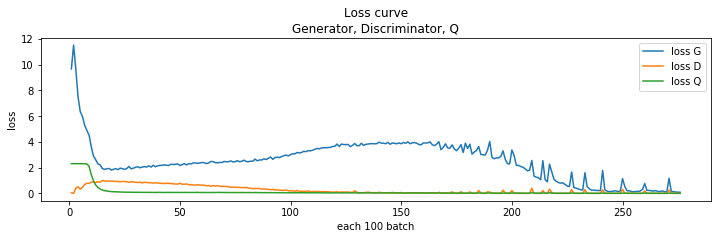

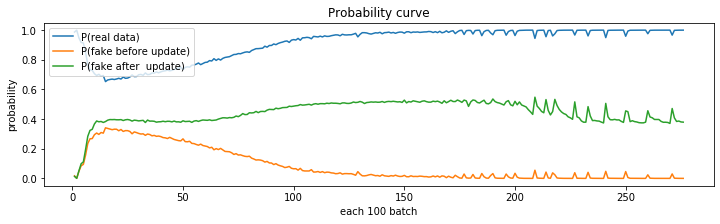

In [202]:
showCurve(t.metrics)

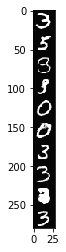

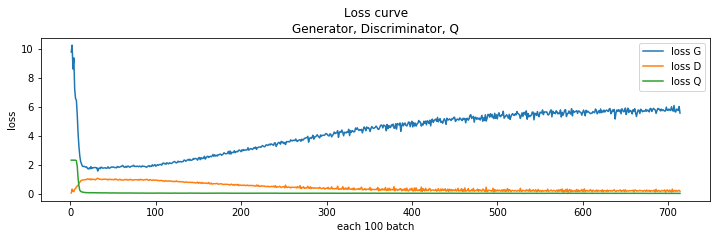

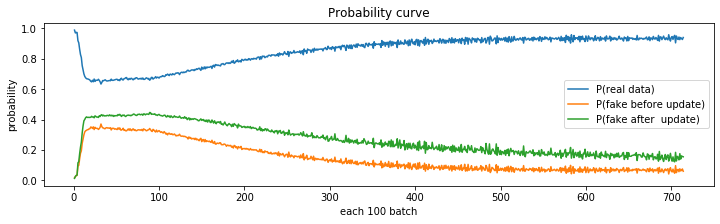

In [318]:
t = load_trainer('.')
def evaluation(self, noise_num=10, seed=None):
    if seed is None:
        import time
        seed = time.time()
    self.generator.eval()
    x = []
    torch.manual_seed(seed)
    for i in range(noise_num):
        z, _ = self._noise_eval()
        x.append( self.generator(z) )
    x = torch.cat(x, dim=0) 
    self.generator.train() 
    return x.detach().cpu()
def evaluation_with_idx(self, idxs, seed=None):
        
    if seed is None:
        import time
        seed = time.time()
        
    self.generator.eval()
        
    x = []
    torch.manual_seed(seed)
        
    z, _ = self._noise_idx(idxs)
        
    x = self.generator(z)
        
    self.generator.train()
        
    return x.detach().cpu()
vec = np.ones(([10, 1]), dtype=np.int16 )
vec *=4    #idx:number = [0:0, 1:2, 2:4, 3:2, 4:3, 5:6, 6:1, 7:9, 8:7, 9:8]
#convertDataToImage(evaluation_with_idx(t,np.squeeze(vec)),10,1)
plt.imshow(convertDataToImage(evaluation_with_idx(t,np.squeeze(vec)),10,1), cmap='gray')
#convertDataToImage(evaluation_with_idx(t,np.squeeze([1,1,1,1,1,1,1,1,1,1])),1,10)
#showImage(evaluation(t))
showCurve(t.metrics)